# Detect Bad Data in Sensor Measurements from a Power System

In this exercise, we consider a simple power system on 2 nodes. Suppose the
power flow relations are given by linear DC power flow equations. Let the phase angle at bus 1 be zero. Therefore, the power flowing from bus 1 to
bus 2 is given by 


$$p = \frac{(0 - \theta)}{x_{12}},$$ 

where 

$\theta$: the phase angle at bus 2. We take $\theta_1 = 0$ without loss of generality.

$x_{12}$:the reactance of the line joining buses 1 and 2

Suppose we are given sensor data on '$\theta$' and '$p$'. We will assume that the angle and power flow
measurements have additive white Gaussian noise. Furthermore, we will corrupt a
collection of the measurements in a way that does not correspond to our error
model. The goal is to train a classifier that distinguishes between normal noisy
data and ones that are corrupted in a different way. We will study how different
kernels can be useful.

### The customary imports

In [1]:
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from IPython.display import Image

### Create the data for the 2 bus network.

In [2]:
nDataPoints = 1000
nCorrupt = 450

# Sample values for thetas mainly in the range of -1.0 to -0.5
theta = np.random.normal(-0.5, 0.2, nDataPoints)

# Calculate power flow from the theta, given by p = (0 - theta)/x12.
# Assume x12 = 2.5
powerFlow = (np.zeros_like(theta) - theta)/2.5

# We will now create good measurements from this data by adding Gaussian noise
# to the data 'theta' and 'powerFlow'.
theta = [t * (1 + np.random.normal(0, 0.05)) for t in theta]
powerFlow = [p * (1 + np.random.normal(0, 0.05)) for p in powerFlow]



Next, we intentionally corrupt the first 'nCorrupt' of the data by adding a quantity that is not representative of our error model. We aim to study what nature of corruption is easier or difficult to detect, etc. Specifically, we shall study 3 different models:
    1. 'corruptionModel' = 1 : Add a random number with a bias to one of the measurements chosen at random. 
    2. 'corruptionModel' = 2 : Add a random number without bias to one of the measurements chosen at random. 
    3. 'corruptionModel' = 3 : Add a random number with a bias to both the measurements.
    
In all these cases, we will multiply either a uniform or a normal random number multiplied by the variable 'multiplicationFactor'.



In [3]:
# Choose a corruption model
corruptionModel = 2
multiplicationFactor = 0.5

for index in range(nCorrupt):
    if corruptionModel == 1:
        if np.random.random() > 0.5:
            theta[index] += multiplicationFactor * np.random.rand()
        else:
            powerFlow[index] += multiplicationFactor * np.random.rand()
    elif corruptionModel == 2:
        if np.random.random() > 0.5:
            theta[index] += multiplicationFactor * np.random.randn()
        else:
            powerFlow[index] += multiplicationFactor * np.random.randn()
    else:
            theta[index] += multiplicationFactor * np.random.rand()
            powerFlow[index] += multiplicationFactor * np.random.rand()


Stack the vectors 'theta' and 'powerFlow' into a joint matrix 'X'. It is always a good practice to scale your data to run SVM. Notice that we are cheating a little as we scale the entire data set 'X', because our training and test sets are derived from 'X'. Ideally, one would have to scale the training and test sets separately.


In [4]:
X = np.column_stack((theta, powerFlow))
X = preprocessing.StandardScaler().fit_transform(X)
Y = np.concatenate((np.ones(nCorrupt), np.zeros(nDataPoints-nCorrupt)))

# Generate training and test sets. Recall from the first lab that 'test_size'
# determines what fraction of the data becomes your test set.
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=.2)

Define the support vector machine classifier. We will use the SVC library that is part of sklearn.svm. Two different questions are of interest:
    
   1. What is the effect of different kernels? Specifically explore 'linear' and 'rbf' (radial basis function) kernels  with different corruption model.

   2. What is the effect of the choice of the hyper-parameters 'C' and 'gamma'? The parameter 'degree' is only active when you use a polynomial kernel. It defines the degree of the polynomial that is used to define the kernel. The variable 'max_iter' prevents svm from taking too long to compute the results. It may, however, throw a warning that your classification task has not converged. Compare the combinations: (C=1, gamma=1), (C=0.001, gamma=1), (C=1, gamma=100). Do these experiments with corruptionModel=2.

In [5]:
clf = svm.SVC(C=1, gamma=1, kernel='rbf', max_iter=100000)
clf.fit(trainX, trainY)
predictY = clf.predict(testX)

### Refresher on the 'C' and 'gamma' parameters of SVM

To understand the definition of $C$, recall how SVM works for linearly separable data with hard margins. You are given labeled data $(x_1, y_1), \ldots, (x_n, y_n)$, where $y_i \in \{-1, +1\}$. Then, SVM seeks $w$ that solves
\begin{align}
& \text{minimize} && \frac{1}{2}w^T w,\\
& \text{subject to} && y_i (x_i^T w + b) \geq 1, \quad i = 1,\ldots,n.
\end{align}

**Question.** Interpret the objective and the constraint.

For data that may not be linearly separable, this problem may not be feasible. Replace with a soft margin, i.e., allow constraint violation but penalize the extent of the violation. With soft margin, you solve
\begin{align}
& \text{minimize} && \frac{1}{2}w^T w + C \sum_{i=1}^n \xi_i,\\
& \text{subject to} && y_i (x_i^T w + b) \geq 1 - \xi_i, \\
&&& \xi_i \geq 0, \\
&&& i = 1,\ldots,n.
\end{align}

**Question.** Interpret the objective.

A convex optimization problem is (roughly) equivalent to its dual problem. For the problem with soft margins, its dual is given by
\begin{align}
& \text{maximize} && \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{j, k=1}^n \alpha_j \alpha_k y_j y_k x_j^T x_k ,\\
& \text{subject to} && \sum_{i=1}^n \alpha_i y_i = 0, \\
&&& 0 \leq \alpha_i \leq C.
\end{align}

The required $w$ is then given by
$$ w = \sum_{i=1}^n \alpha_i y_i x_i.$$

The last optimization problem requires the dot product $x_j^T x_k$. Recall that $x$ represents the features of the data. One can think about a transformed feature space $\phi(x)$ and run the optimization problem on that space.

\begin{align}
& \text{maximize} && \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{j, k=1}^n \alpha_j \alpha_k y_j y_k  \phi(x_j)^T \phi(x_k) ,\\
& \text{subject to} && \sum_{i=1}^n \alpha_i y_i = 0, \\
&&& 0 \leq \alpha_i \leq C.
\end{align}

Rather than knowing the exact transformation $\phi$, we only need to know how to compute the dot product $\phi(x_j)^T \phi(x_k)$. Radial basis functions define such a dot product
$$\phi(x_j)^T \phi(x_k) := \gamma \| x_j - x_k \|^2. $$

How do you classify using this learning module? Your prediction for an input $x$ is given by
$$ \hat{y} := \sum_{i=1}^n \alpha_i y_i \phi(x_i)^T \phi(x) + b. $$

Here, $b$ can also be computed from the $\alpha$'s, not shown here.

**Question.** How do you expect $\gamma$ to affect the decision function?

### Back to the 2-bus example. Reporting the performance of classification.

The following 'classification_report' is a convenient way to understand how good your classifier has performed. Our goal here is to understand specifically what the values 'precision' and 'recall' mean and how different parameters affect these values. 

A useful article to read about 'precision' and 'recall': https://en.wikipedia.org/wiki/Precision_and_recall

Specifically, read the example about identifying images of cats versus dogs. 

In [6]:
print(classification_report(testY, predictY))

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       110
         1.0       0.99      0.77      0.86        90

   micro avg       0.89      0.89      0.89       200
   macro avg       0.91      0.88      0.89       200
weighted avg       0.90      0.89      0.89       200



Compare the results with svm's internal accuracy score. How does it vary with the prevalence of corrupt data? Basically, 'score' only cares about the overall performance and does not quite weigh in the fact that one class may have way more data than the other. The detailed classification report in the last step allows you to understand how well you are doing on each class separately.

In [7]:
print("Accuracy score of SVM = %1.2f" % clf.score(testX, testY))

Accuracy score of SVM = 0.89


Part of understanding the nature of the SVM classifier relies on a way to visualize the output of the classifier. Here, we will scatter plot the test data set and add to it a heat map of the 'decision_function', which measures the distance of a point to the classifying surface. To create a heat map for the decision function, we need to create a meshgrid over the space of (scaled) 'theta' and 'powerFlow' from the test data set.


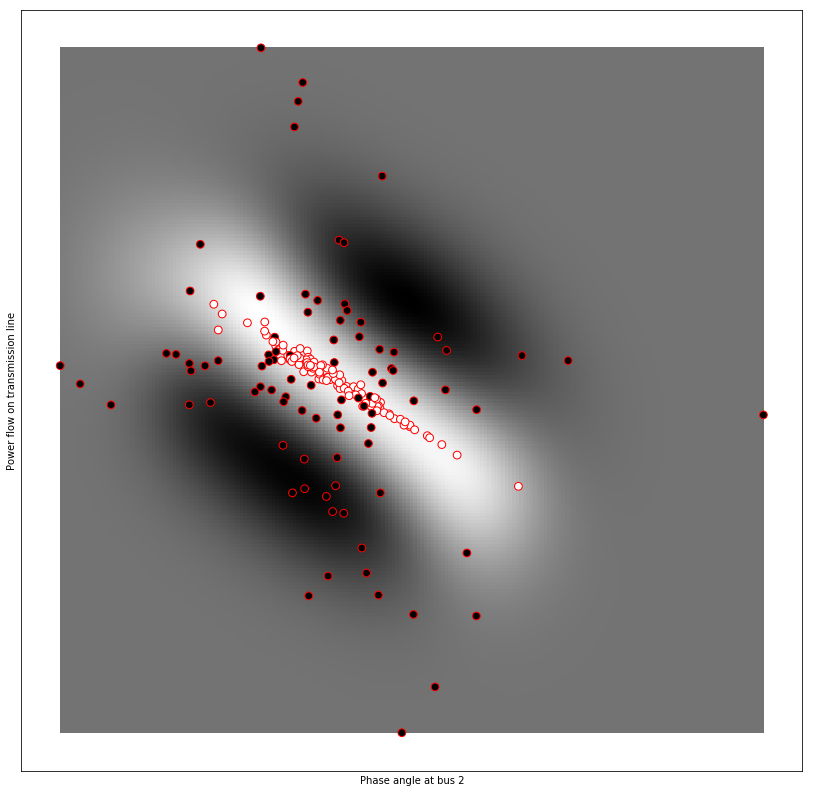

In [8]:
# Create the meshgrid.
testX = np.array(testX)
xx, yy = np.meshgrid(np.linspace(np.min(testX[:, 0]), np.max(testX[:, 0]), 200),
                     np.linspace(np.min(testX[:, 1]), np.max(testX[:, 1]), 200))

# Evaluate the decision function on the grid created by 'xx', 'yy'. To do so, use
# the 'ravel' function to create a 1-D array out of 'xx' and 'yy', then pass it to
# the routine 'decision_function' from svc, and finally reshape the array to make
# it into a matrix of values over a meshgrid again.
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(14, 14))

# Draw the heat map of the decision function.
colorMap = plt.get_cmap('binary')
plt.pcolormesh(xx, yy, Z, cmap=colorMap)


# Draw a scatter plot of the test data.
plt.scatter(testX[:, 0], testX[:, 1], s=60, c=testY, cmap=colorMap, edgecolors='r')

# Label the axes, remove the ticks, and show the plot.
plt.xlabel('Phase angle at bus 2')
plt.ylabel('Power flow on transmission line')
plt.xticks(())
plt.yticks(())
plt.axis('tight')
plt.show()